<a href="https://colab.research.google.com/github/gimoonnam/DataScienceRelatedStudy/blob/master/motionAnalysisMulti_pickles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount to Google Drive to access to dataset 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
cd gdrive/MyDrive/DT/

/content/gdrive/MyDrive/DT


# Import modules 

In [ ]:
import os 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import glob
import time

from collections import Counter
from collections import OrderedDict

# Load all data

## Define an object class for analysis 

In [ ]:
class motionAnalysis:
    def __init__(self, collectedDate):        
        currPath = os.getcwd()

        if "Data" not in os.listdir(currPath): 
            raise ValueError('directory Data is not found')

        self.Path = os.path.join(currPath, "Data", collectedDate, "preprocessedData")
        self.df = {}
        self.selectedMotions = {} 
        self.filteredMotions = {} 
        self.flattenVector = {}
    
    
    def load_data(self):
        pklfiles = [f for f in os.listdir(self.Path) if "pkl" in f]
        for f in pklfiles: 
            spl = f.split("_")
            key = os.path.join(*spl[1:4] , spl[-1][:-4])
            self.df[key] = pd.read_pickle(os.path.join(self.Path,f))

        self.sources = sorted(list(self.df.keys()))
        
    def __repr__(self):
        return '\n'.join([
            f'data container : {"self.df"}',
            f'keys container : {"self.sources"}',
            f'selected motions: {"self.selectedMotions"}',
            f'filtered motions for network train : {"self.filteredMotions"}',
            f'list of loaded data: {len(self.sources)}'])
            #f'list of keys: {[s for s in self.sources]}'])
                        

distanceList = ["1m","2m","3m","4m","5m"]        
cornerList = ['left', 'right']

In [ ]:
motions = motionAnalysis(collectedDate="run070120")
motions.load_data()
motions

data container : self.df
keys container : self.sources
selected motions: self.selectedMotions
filtered motions for network train : self.filteredMotions
list of loaded data: 84

## Plotting some trajectories

In [ ]:
def plottingMotions(self, measurement_setup): 
    
    selectedKeys = [k for k in self.sources if measurement_setup in k]
    n_subs = len(selectedKeys) 
    
    if n_subs == 0:
        raise ValueError('called data does not exist')

    fig = plt.figure(figsize=(14, 5), constrained_layout=False)
    axs = fig.subplots(n_subs, 1)
    plt.suptitle(measurement_setup, fontsize=20)

    for i,s in enumerate(selectedKeys):
        axs[i].plot(self.df[s]['derivative'],'g', linewidth=0.5)
        axs[i].set_title(s[len(measurement_setup)+1:] , y=1.0, pad=-12, color='b')
        if i == n_subs-1: 
            plt.xlabel("time index")

motionAnalysis.plottingMotions = plottingMotions            

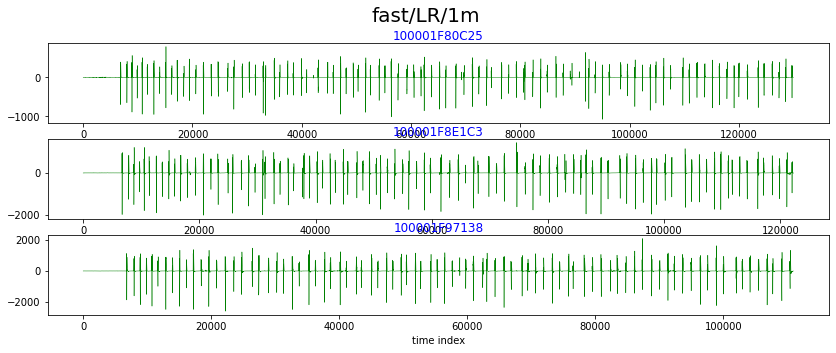

In [ ]:
motions.plottingMotions("fast/LR/1m")

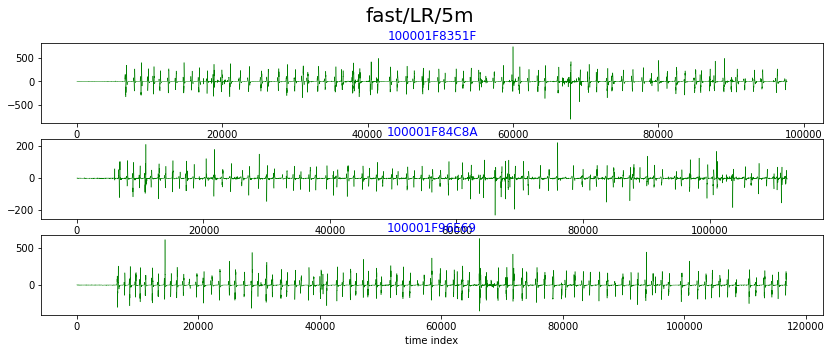

In [ ]:
motions.plottingMotions("fast/LR/5m")

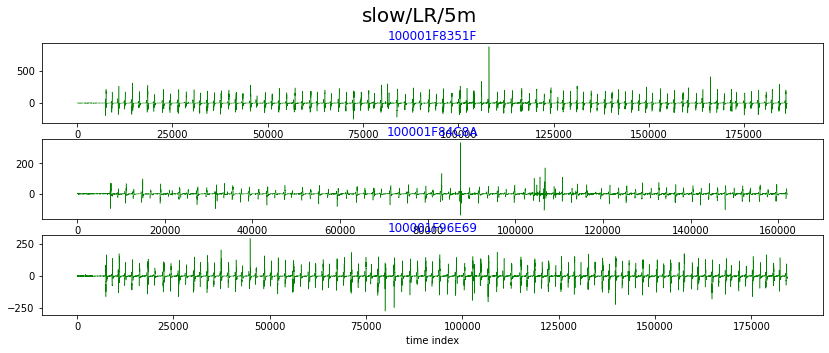

In [ ]:
motions.plottingMotions("slow/LR/5m")

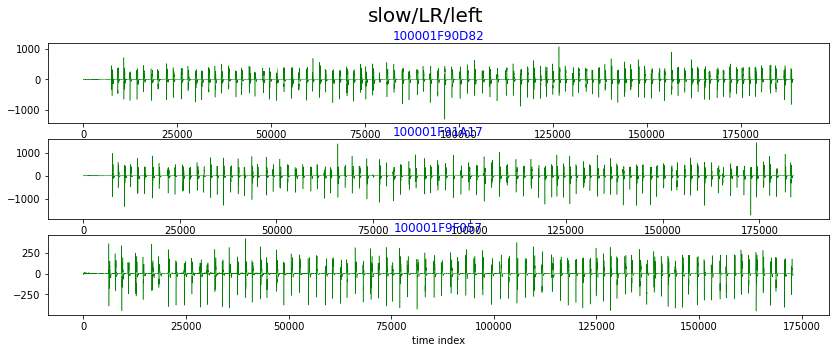

In [ ]:
motions.plottingMotions("slow/LR/left")

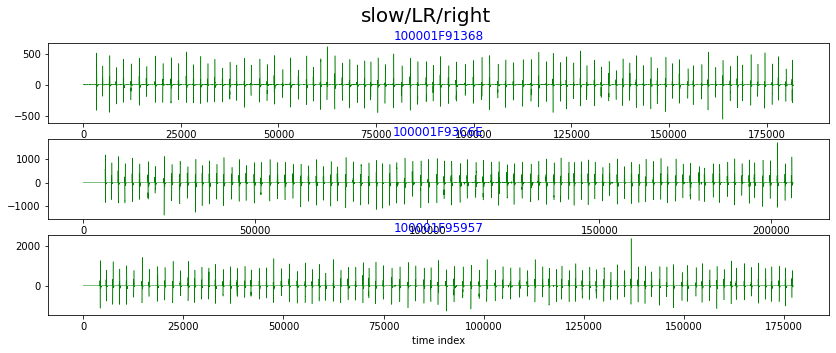

In [ ]:
motions.plottingMotions("slow/LR/right")

# Data Analysis 
## Extract individual motions 

In [ ]:
def getSelectedMotions(self,measurement_setup): 
    
    self.selectedMotions[measurement_setup] = []

    selectedKeys = [k for k in self.sources if measurement_setup in k]
    n_subs = len(selectedKeys) 
    
    if n_subs == 0:
        raise ValueError('called data does not exist')

    self.targetLength = 1200

    for key in selectedKeys:         
        motions = self.getMotionsFromSingleTrajectory(self.df[key].copy())
        for m in motions:

            if self.targetLength - m.shape[0] < 0: 
                m=m.drop(index=[i for i in range(m.shape[0]-1,self.targetLength-1,-1)])
                size=0
            else: 
                size = self.targetLength-m.shape[0]

            buf = pd.DataFrame(np.zeros(shape=(size,2)), columns=['time','derivative'])
            self.selectedMotions[measurement_setup].append(pd.concat([m, buf], join='inner').reset_index(drop=True))

def getMotionsFromSingleTrajectory(self, df):
    # todo: come up with a way of removing this option 
    pd.options.mode.chained_assignment = None

    df['abs'] = df['derivative'].abs()

    timeout, triggerLevel = 200, 20

    temp = df['abs'].rolling(timeout).max()
    df['gating'] = temp.apply(lambda x: 1 if x > triggerLevel else 0)

    df['gating_shifted'] = df['gating'].shift(fill_value=pd.NaT)
    df['gating_diff'] = df['gating'] - df['gating_shifted']
    df.dropna(inplace=True)

    # Todo: come up with a better implementation... 
    df['start'] = df[['time','gating_diff']].apply(lambda x: x[0] if x[1] > 0 else -1, axis=1)
    df['stop']  = df[['time','gating_diff']].apply(lambda x: x[0] if x[1] < 0 else -1, axis=1)

    df_starts = df[df['start'] > 0].index
    df_stops = df[df['stop'] > 0].index

    selectedMotionsSingle = [] 
    for i, (start, stop) in enumerate(zip(df_starts, df_stops)): 
        s = slice(start,stop)
        dtemp = df['derivative'][s].values
        powerEstimator = np.max(np.abs(dtemp)) + np.abs(np.max(dtemp)) + np.abs(np.min(dtemp))         
        if powerEstimator > 100: 
            selectedMotionsSingle.append(
                pd.concat([df.time[s], df['derivative'][s]], axis=1).reset_index(drop=True))

    return selectedMotionsSingle
    
motionAnalysis.getSelectedMotions = getSelectedMotions
motionAnalysis.getMotionsFromSingleTrajectory = getMotionsFromSingleTrajectory

In [ ]:
distanceList

['1m', '2m', '3m', '4m', '5m']

## extract individual motions 
### for distant sensors

In [ ]:
def extractIndividualMotions(direction, distanceList):
    for dis in distanceList:
        setup = os.path.join("fast", direction, dis)
        motions.getSelectedMotions(setup)
        print("for {}, number of motions is {}".format(setup,len(motions.selectedMotions[setup])))    

    print("")
    for dis in distanceList:
        setup = os.path.join("slow", direction, dis)
        motions.getSelectedMotions(setup)
        print("for {}, number of motions is {}".format(setup,len(motions.selectedMotions[setup])))            

In [ ]:
extractIndividualMotions("LR",distanceList)

for fast/LR/1m, number of motions is 277
for fast/LR/2m, number of motions is 268
for fast/LR/3m, number of motions is 269
for fast/LR/4m, number of motions is 253
for fast/LR/5m, number of motions is 262

for slow/LR/1m, number of motions is 292
for slow/LR/2m, number of motions is 279
for slow/LR/3m, number of motions is 283
for slow/LR/4m, number of motions is 285
for slow/LR/5m, number of motions is 252


In [ ]:
extractIndividualMotions("RL",distanceList)

for fast/RL/1m, number of motions is 289
for fast/RL/2m, number of motions is 278
for fast/RL/3m, number of motions is 280
for fast/RL/4m, number of motions is 274
for fast/RL/5m, number of motions is 276

for slow/RL/1m, number of motions is 266
for slow/RL/2m, number of motions is 260
for slow/RL/3m, number of motions is 260
for slow/RL/4m, number of motions is 262
for slow/RL/5m, number of motions is 257


### for corner sensors

In [ ]:
extractIndividualMotions("LR",cornerList)

for fast/LR/left, number of motions is 285
for fast/LR/right, number of motions is 261

for slow/LR/left, number of motions is 285
for slow/LR/right, number of motions is 289


In [ ]:
extractIndividualMotions("RL",cornerList)

for fast/RL/left, number of motions is 288
for fast/RL/right, number of motions is 281

for slow/RL/left, number of motions is 258
for slow/RL/right, number of motions is 259


# Clustering individual motions

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

def clusteringMotions(self, measurement_setup, _n_clusters=20):
    
    currMotions = self.selectedMotions[measurement_setup].copy()

    self.n_clusters = _n_clusters
    self.X = np.expand_dims(currMotions[0]['derivative'].values, axis=0) 
    
    for s in currMotions[1:]:
        self.X = np.vstack((self.X, np.expand_dims(s['derivative'].values, axis=0)))

    model = AgglomerativeClustering(n_clusters=self.n_clusters, affinity="euclidean", linkage='ward')
    model.fit(self.X)

    self.labels = model.labels_
    assert len(self.labels) == len(currMotions)
    del currMotions 
    
    self.dic_labels = OrderedDict(sorted(Counter(self.labels).items()))

    self.ListPlotOfClusteredMotions(measurement_setup)
            
def ListPlotOfClusteredMotions(self, measurement_setup):
    
    fig = plt.figure(figsize=(14, 8), constrained_layout=False)
    axs = fig.subplots(self.n_clusters//2, 2)
    
    plt.suptitle(measurement_setup, fontsize=20)
    
    for l in range(self.n_clusters//2):     
        for c in self.X[self.labels==l,:]: axs[l, 0].plot(c,'b', linewidth=0.5)

        subtitle = str(self.X[self.labels==l].shape[0]) + " (label: " + str(l) + ")" 
        axs[l, 0].set_title(subtitle, y=1.0, pad=-12)

        if l < self.n_clusters//2-1: 
            axs[l, 0].set(xticks=[])

        dl = self.n_clusters//2
        for c in self.X[self.labels==l+dl,:]: axs[l, 1].plot(c,'b', linewidth=0.5)
        subtitle = str(self.X[self.labels==l+dl].shape[0]) + " (label: " + str(l+dl) + ")"     
        axs[l, 1].set_title(subtitle, y=1.0, pad=-12)
        if l < self.n_clusters//2-1: 
            axs[l, 1].set(xticks=[])    
            
def filteringMotionsForTraining(self, measurement_setup, keepingLabel): 
    n_filteredMotions = sum(list(map(lambda x: self.dic_labels[x], keepingLabel)))

    self.filteredMotions[measurement_setup] = self.X[self.labels == keepingLabel[0], :]

    for l in keepingLabel[1:]: 
        self.filteredMotions[measurement_setup] = np.vstack((self.filteredMotions[measurement_setup], self.X[self.labels == l, :]))

    assert self.filteredMotions[measurement_setup].shape[0] == n_filteredMotions
    
    print("number of extracted motions for network train: {}".format(n_filteredMotions))
            
motionAnalysis.clusteringMotions = clusteringMotions
motionAnalysis.ListPlotOfClusteredMotions = ListPlotOfClusteredMotions 
motionAnalysis.filteringMotionsForTraining = filteringMotionsForTraining

##  fast / LR 

### 1m 

number of extracted motions for network train: 228


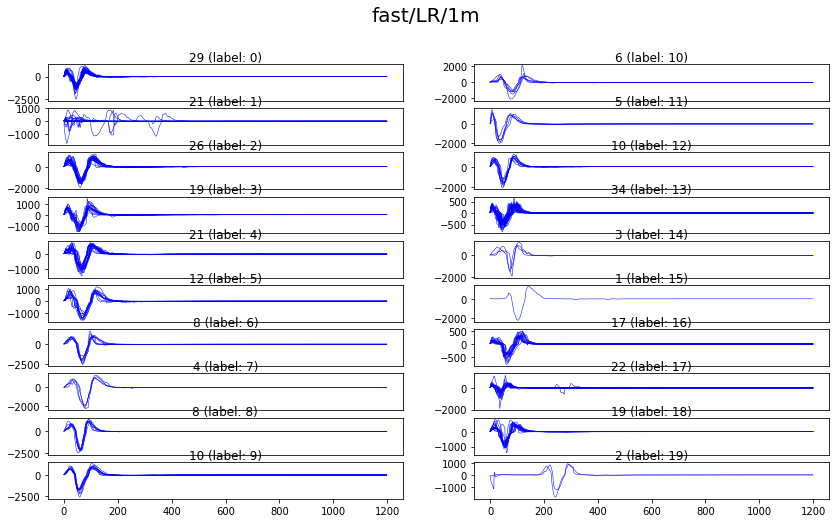

In [ ]:
measurement_setup = 'fast/LR/1m'
motions.clusteringMotions(measurement_setup)
keepingLabel = [0,2,3,4,5,6,7,8,9,10,11,12,13,16,18]
motions.filteringMotionsForTraining(measurement_setup, keepingLabel)

### 2m 

number of extracted motions for network train: 193


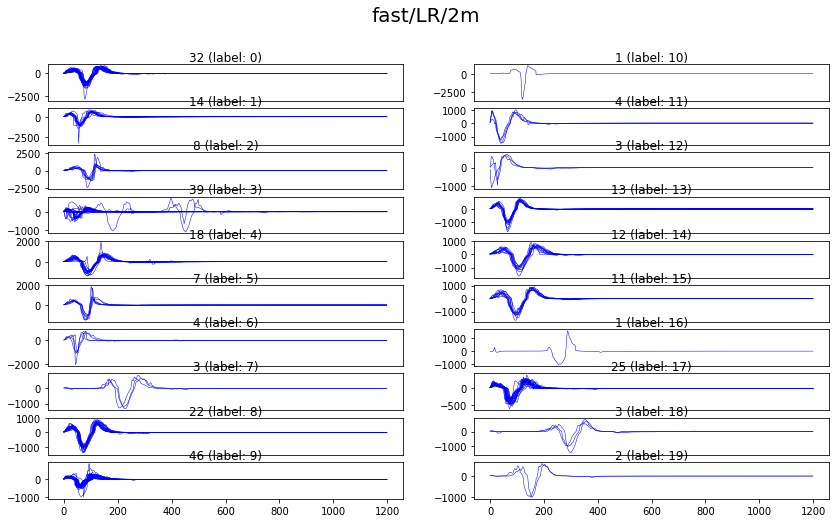

In [ ]:
measurement_setup = 'fast/LR/2m'
motions.clusteringMotions(measurement_setup)
keepingLabel = [0,1,4,8,9,13,14,15,17]
motions.filteringMotionsForTraining(measurement_setup, keepingLabel)

### 3m 

number of extracted motions for network train: 191


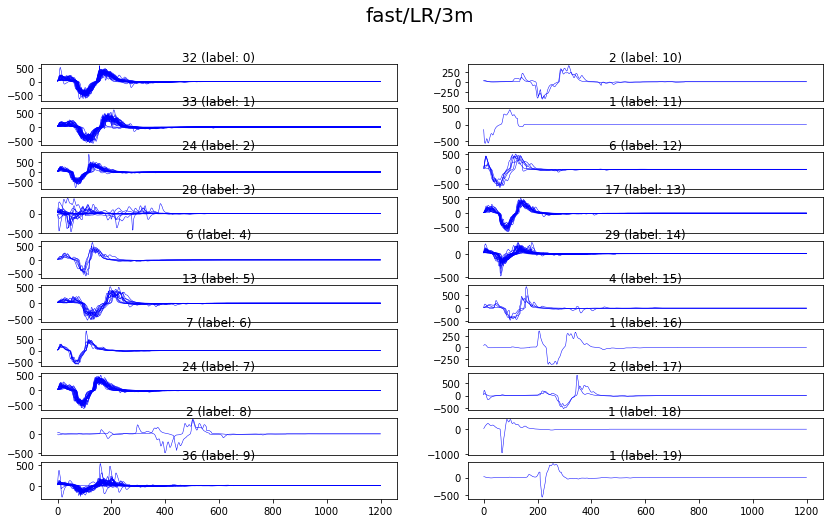

In [ ]:
measurement_setup = 'fast/LR/3m'
motions.clusteringMotions(measurement_setup)
keepingLabel = [0,1,2,4,5,6,7,12,13,14]
motions.filteringMotionsForTraining(measurement_setup, keepingLabel)

### 4m 

number of extracted motions for network train: 147


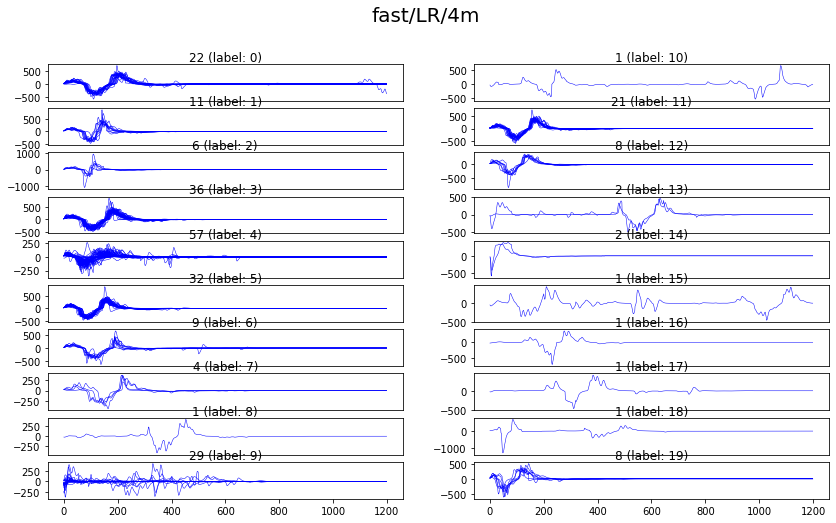

In [ ]:
measurement_setup = 'fast/LR/4m'
motions.clusteringMotions(measurement_setup)
keepingLabel = [0,1,3,5,6,11,12,19]
motions.filteringMotionsForTraining(measurement_setup, keepingLabel)


### 5m 


number of extracted motions for network train: 144


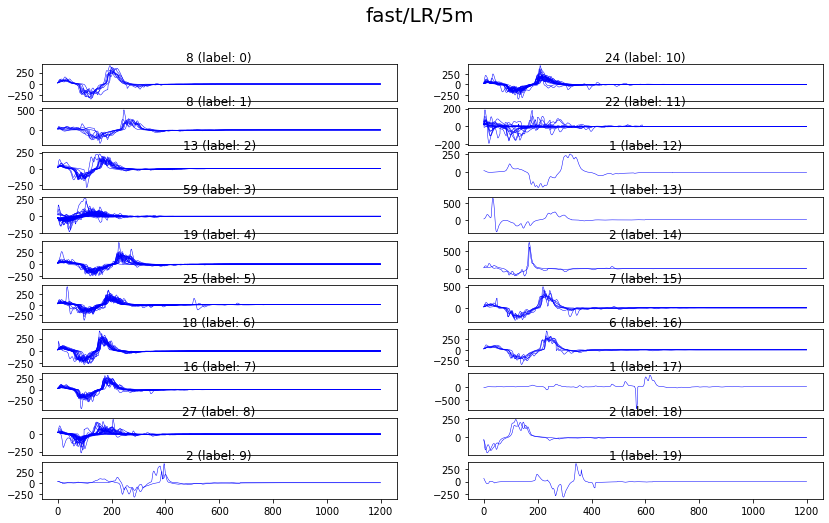

In [ ]:
measurement_setup = 'fast/LR/5m'
motions.clusteringMotions(measurement_setup)
keepingLabel = [0,1,2,4,5,6,7,10,15,16]
motions.filteringMotionsForTraining(measurement_setup, keepingLabel)

## slow / LR 
### 1m 

number of extracted motions for network train: 207


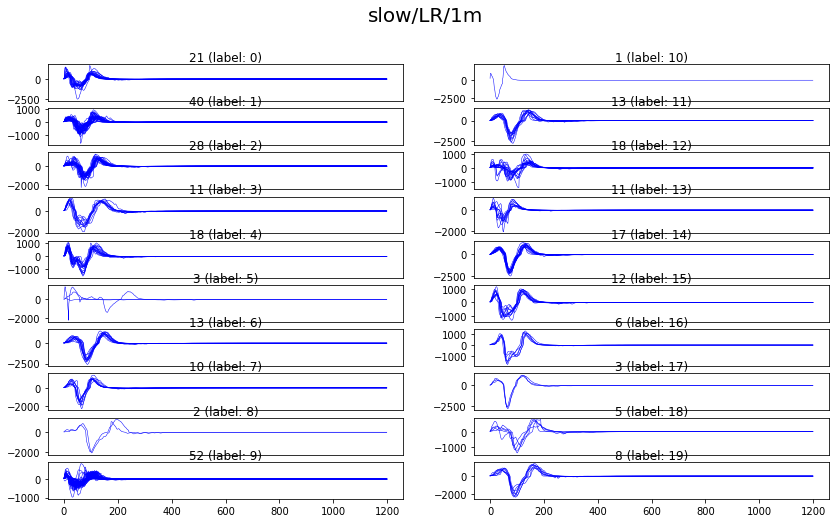

In [ ]:
measurement_setup = 'slow/LR/1m'
motions.clusteringMotions(measurement_setup)
keepingLabel = [0,1,2,3,4,6,7,8,11,14,15,16,17,18,19]
motions.filteringMotionsForTraining(measurement_setup, keepingLabel)

### 2m

number of extracted motions for network train: 184


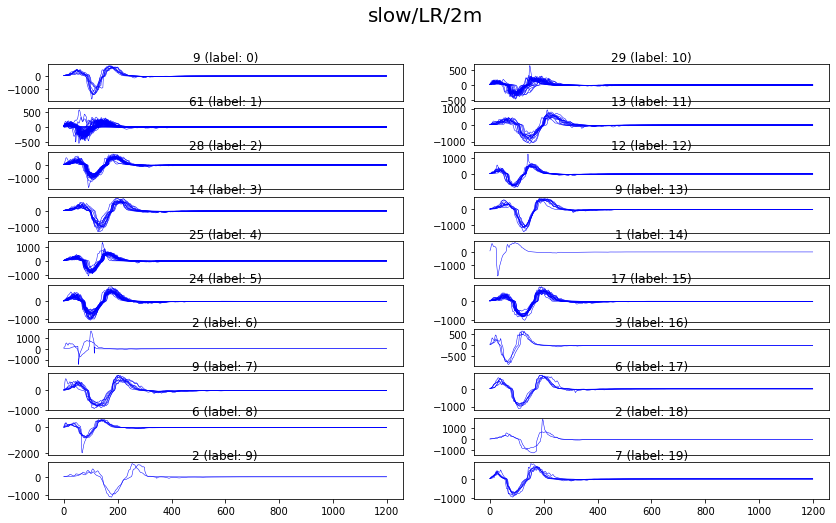

In [ ]:
measurement_setup = 'slow/LR/2m'
motions.clusteringMotions(measurement_setup)
keepingLabel = [0,2,3,4,5,7,8,9,11,12,13,15,16,17,19]
motions.filteringMotionsForTraining(measurement_setup, keepingLabel)

### 3m

number of extracted motions for network train: 229


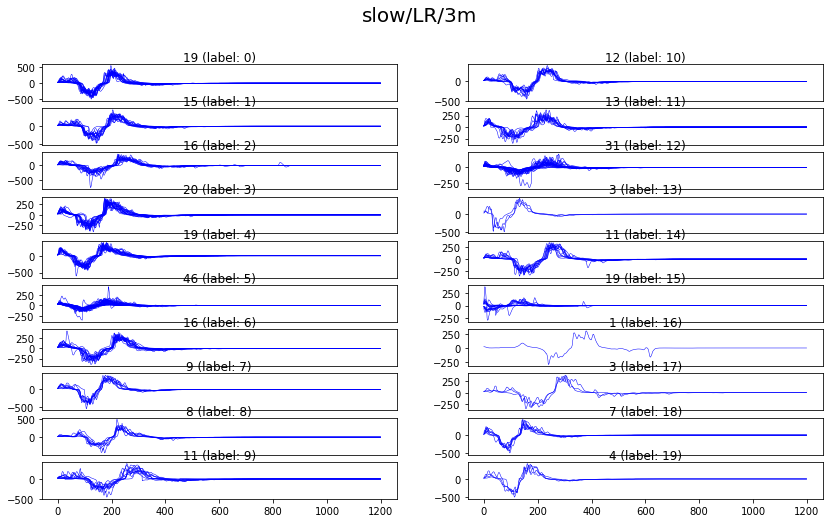

In [ ]:
measurement_setup = 'slow/LR/3m'
motions.clusteringMotions(measurement_setup)
keepingLabel = [0,1,2,3,4,5,6,7,8,9,10,11,14,17,18,19]
motions.filteringMotionsForTraining(measurement_setup, keepingLabel)

### 4m

number of extracted motions for network train: 178


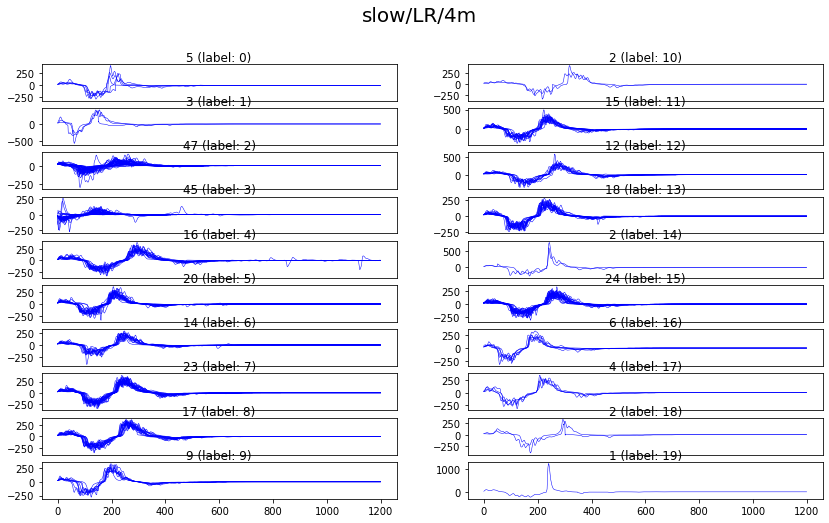

In [ ]:
measurement_setup = 'slow/LR/4m'
motions.clusteringMotions(measurement_setup)
keepingLabel = [4,5,6,7,8,9,11,12,13,15,16,17]
motions.filteringMotionsForTraining(measurement_setup, keepingLabel)

### 5m

number of extracted motions for network train: 124


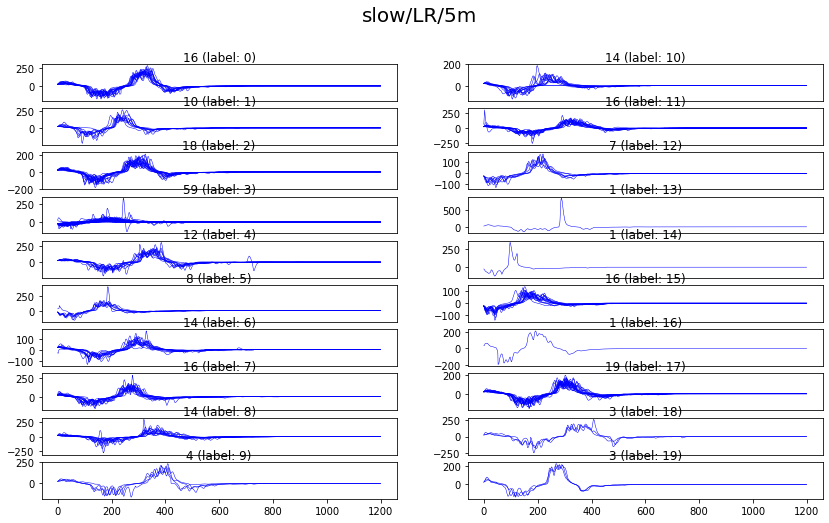

In [ ]:
measurement_setup = 'slow/LR/5m'
motions.clusteringMotions(measurement_setup)
keepingLabel = [0,1,2,4,6,7,11,17,19]
motions.filteringMotionsForTraining(measurement_setup, keepingLabel)

## slow / RL 
### 1m 

number of extracted motions for network train: 195


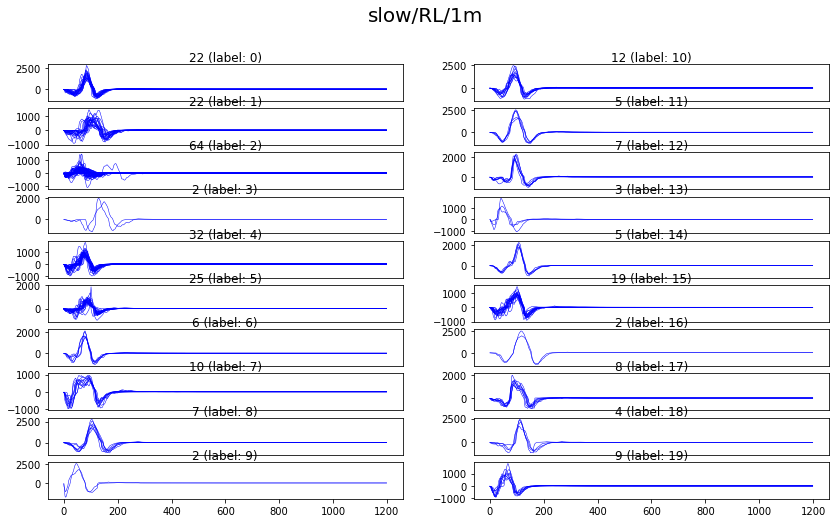

In [ ]:
measurement_setup = 'slow/RL/1m'
motions.clusteringMotions(measurement_setup)
keepingLabel = [0,1,4,5,6,7,8,10,11,12,14,15,16,17,18,19]
motions.filteringMotionsForTraining(measurement_setup, keepingLabel)

### 2m

number of extracted motions for network train: 190


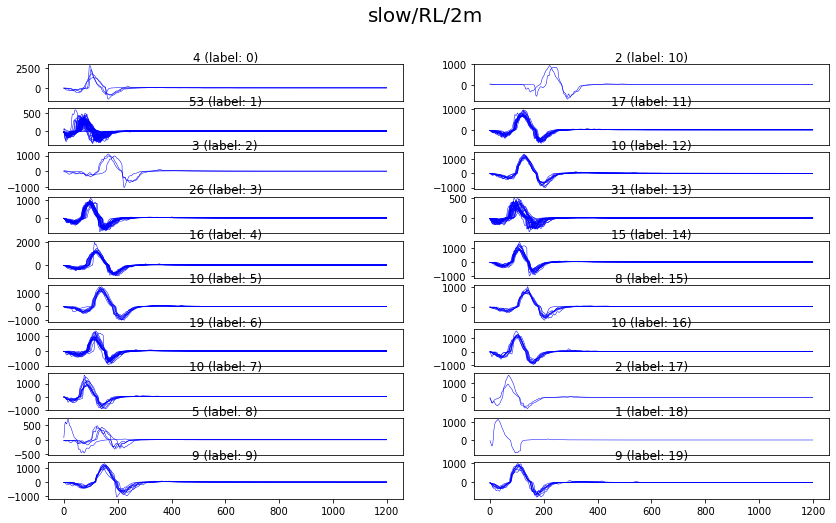

In [ ]:
measurement_setup = 'slow/RL/2m'
motions.clusteringMotions(measurement_setup)
keepingLabel = [3,4,5,6,7,9,11,12,13,14,15,16,19]
motions.filteringMotionsForTraining(measurement_setup, keepingLabel)

### 3m

number of extracted motions for network train: 135


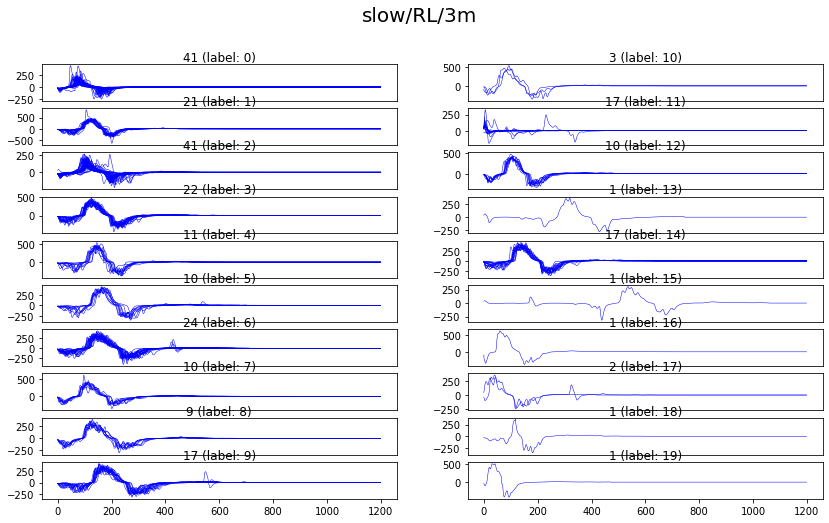

In [ ]:
measurement_setup = 'slow/RL/3m'
motions.clusteringMotions(measurement_setup)
keepingLabel = [1,3,4,5,6,7,8,9,12,13]
motions.filteringMotionsForTraining(measurement_setup, keepingLabel)

### 4m

number of extracted motions for network train: 152


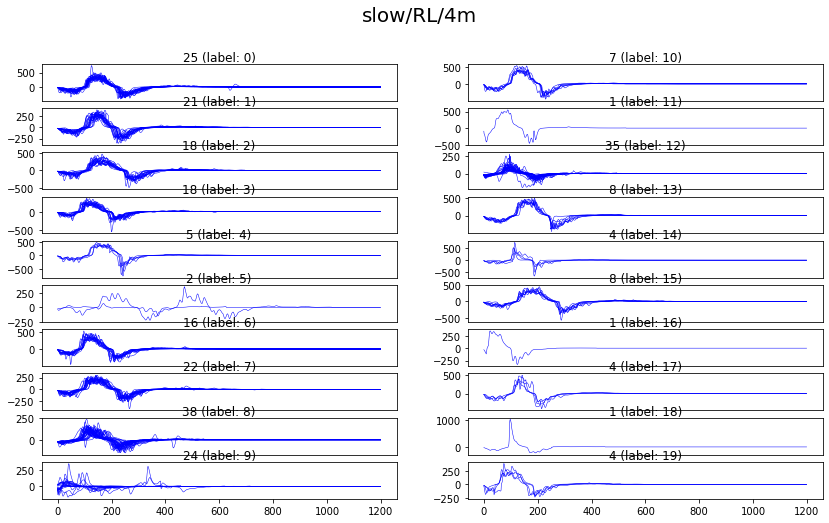

In [ ]:
measurement_setup = 'slow/RL/4m'
motions.clusteringMotions(measurement_setup)
keepingLabel = [0,1,2,3,4,6,7,10,13,15,19]
motions.filteringMotionsForTraining(measurement_setup, keepingLabel)

### 5m 

number of extracted motions for network train: 197


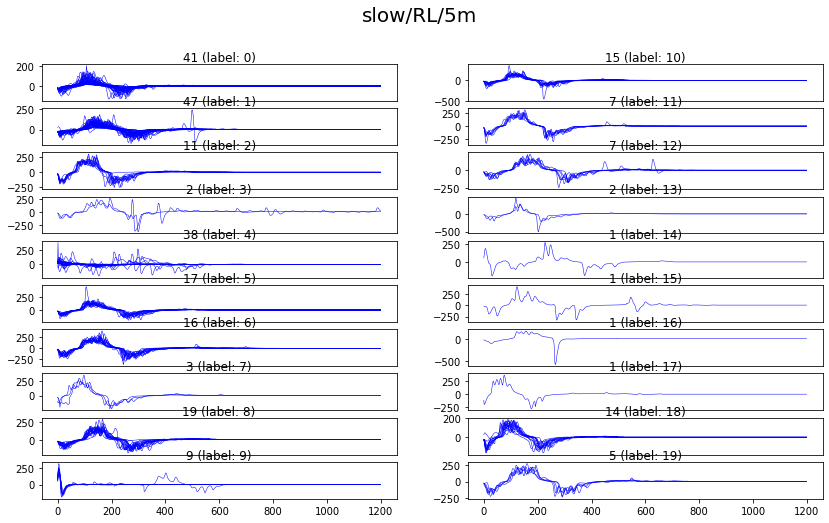

In [ ]:
measurement_setup = 'slow/RL/5m'
motions.clusteringMotions(measurement_setup)
keepingLabel = [0,1,2,5,6,7,8,10,11,12,18]
motions.filteringMotionsForTraining(measurement_setup, keepingLabel)

## fast / RL 
### 1m 

number of extracted motions for network train: 249


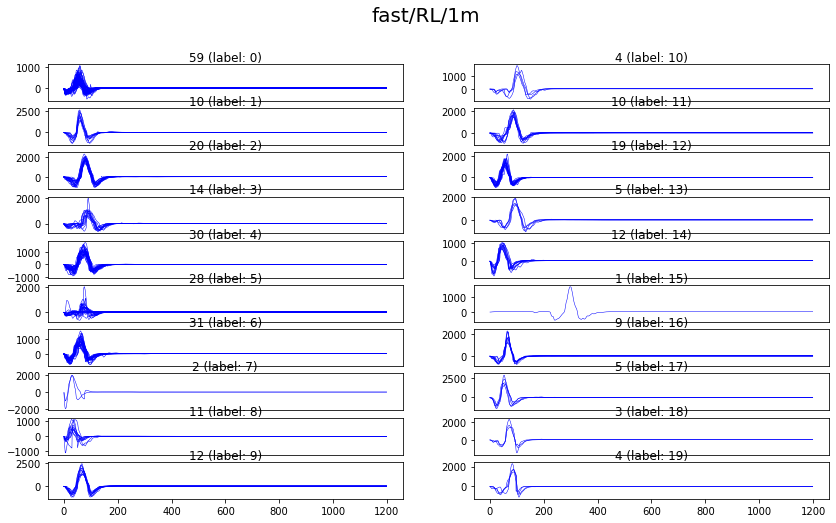

In [ ]:
measurement_setup = 'fast/RL/1m'
motions.clusteringMotions(measurement_setup)
keepingLabel = [0,1,2,3,4,6,7,9,10,11,12,13,14,16,17,18,19]
motions.filteringMotionsForTraining(measurement_setup, keepingLabel)

### 2m

number of extracted motions for network train: 165


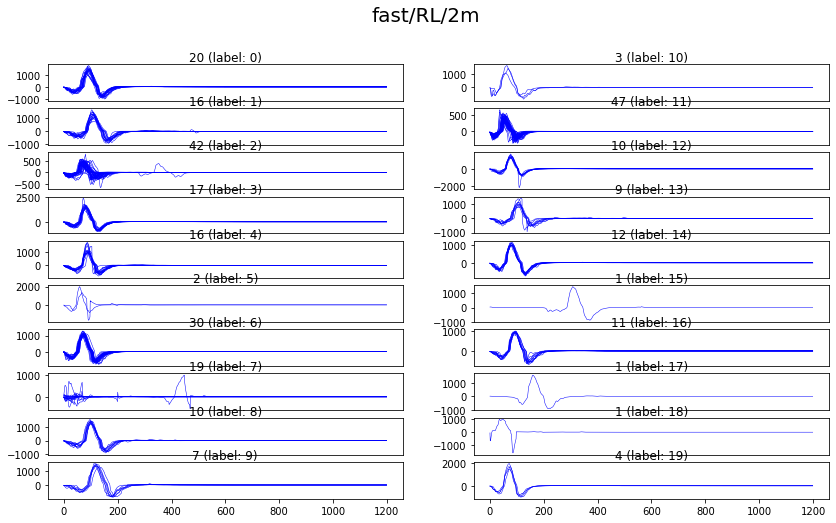

In [ ]:
measurement_setup = 'fast/RL/2m'
motions.clusteringMotions(measurement_setup)
keepingLabel = [0,1,3,4,6,8,9,10,12,13,14,16,19]
motions.filteringMotionsForTraining(measurement_setup, keepingLabel)

### 3m

number of extracted motions for network train: 165


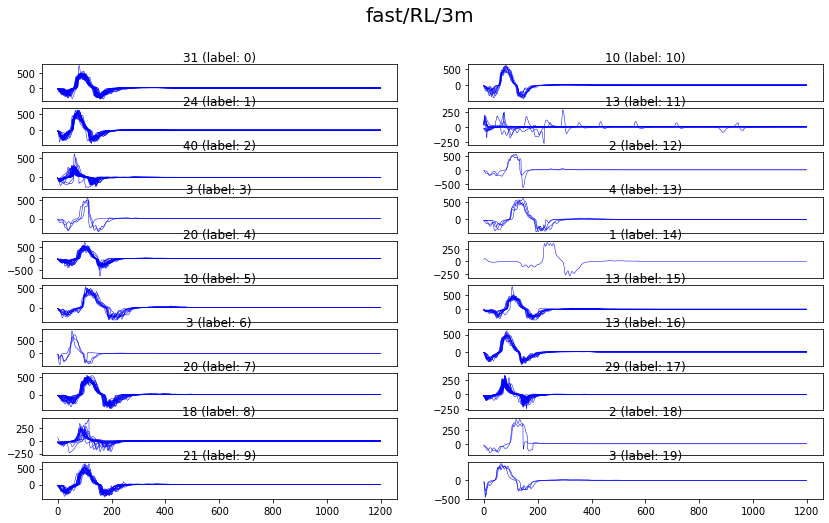

In [ ]:
measurement_setup = 'fast/RL/3m'
motions.clusteringMotions(measurement_setup)
keepingLabel = [0,1,3,4,5,7,9,10,15,16]
motions.filteringMotionsForTraining(measurement_setup, keepingLabel)


### 4m

number of extracted motions for network train: 161


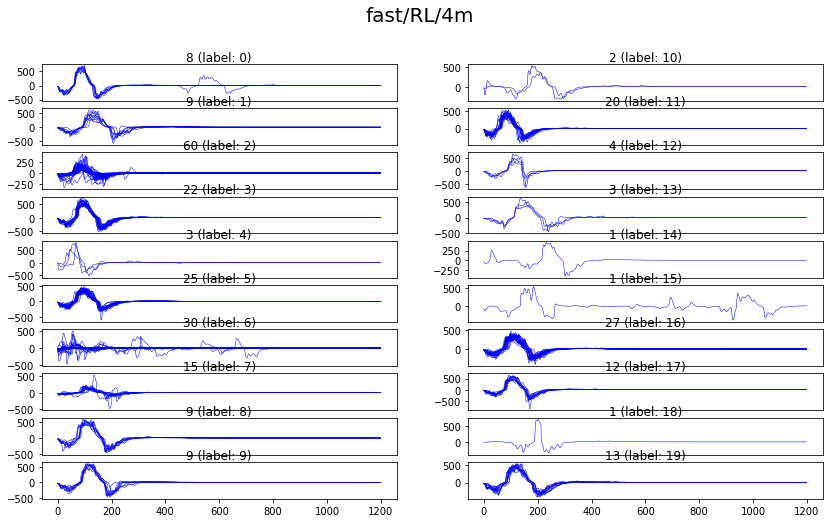

In [ ]:
measurement_setup = 'fast/RL/4m'
motions.clusteringMotions(measurement_setup)
keepingLabel = [0,1,3,5,8,9,11,12,13,16,17,19]
motions.filteringMotionsForTraining(measurement_setup, keepingLabel)

### 5m

number of extracted motions for network train: 193


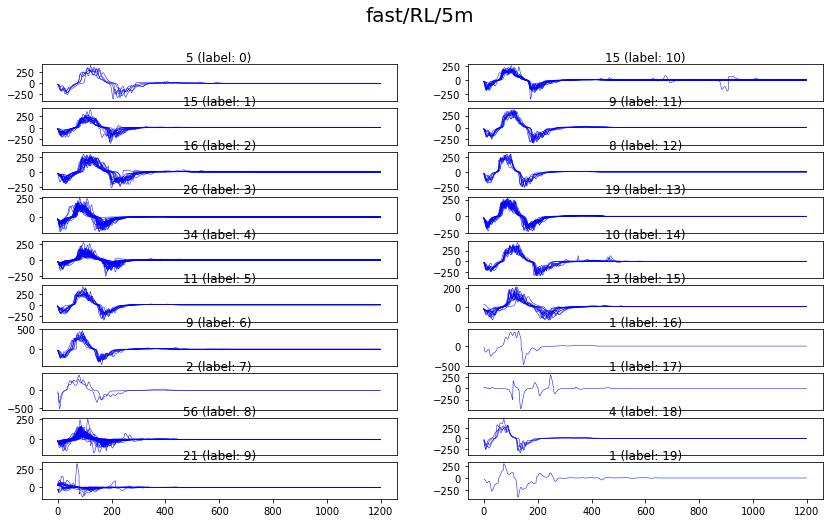

In [ ]:
measurement_setup = 'fast/RL/5m'
motions.clusteringMotions(measurement_setup)
keepingLabel = [0,1,2,3,4,5,6,7,10,11,12,13,14,15,19]
motions.filteringMotionsForTraining(measurement_setup, keepingLabel)

## for corner sensors

### fast  / LR 

#### left 

number of extracted motions for network train: 151


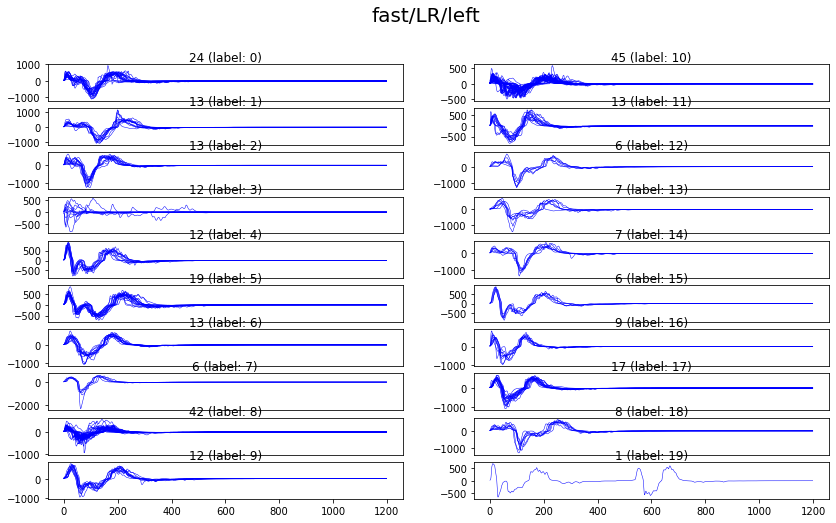

In [ ]:
measurement_setup = 'fast/LR/left'
motions.clusteringMotions(measurement_setup)
keepingLabel = [0,1,2,6,11,10,14,15,17]
motions.filteringMotionsForTraining(measurement_setup, keepingLabel)


#### right

number of extracted motions for network train: 216


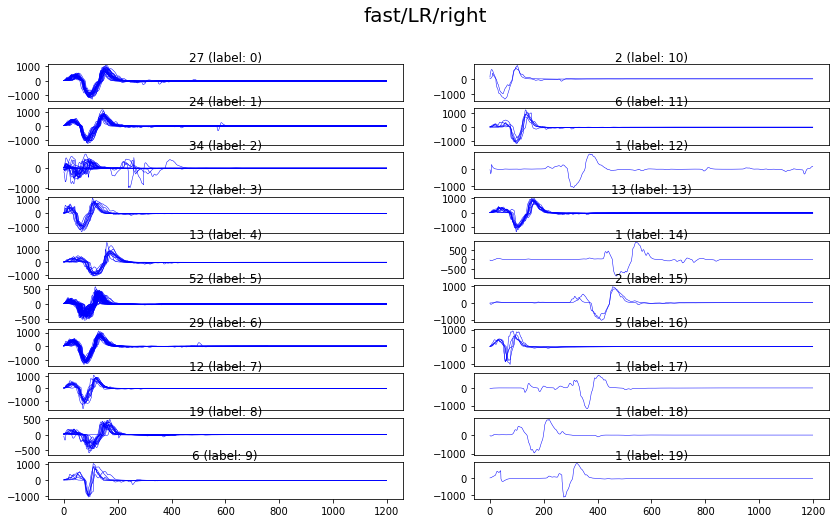

In [ ]:
measurement_setup = 'fast/LR/right'
motions.clusteringMotions(measurement_setup)
keepingLabel = [0,1,3,4,5,6,7,8,9,10,11,13,18]
motions.filteringMotionsForTraining(measurement_setup, keepingLabel)

### slow / LR 

#### left

number of extracted motions for network train: 116


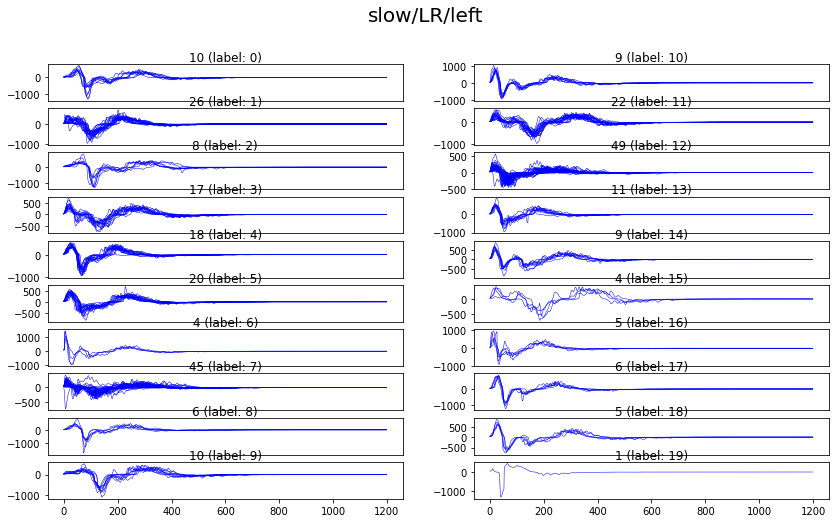

In [ ]:
measurement_setup = 'slow/LR/left'
motions.clusteringMotions(measurement_setup)
keepingLabel = [1,3,5,11,13,14,16,17]
motions.filteringMotionsForTraining(measurement_setup, keepingLabel)

#### right 

number of extracted motions for network train: 207


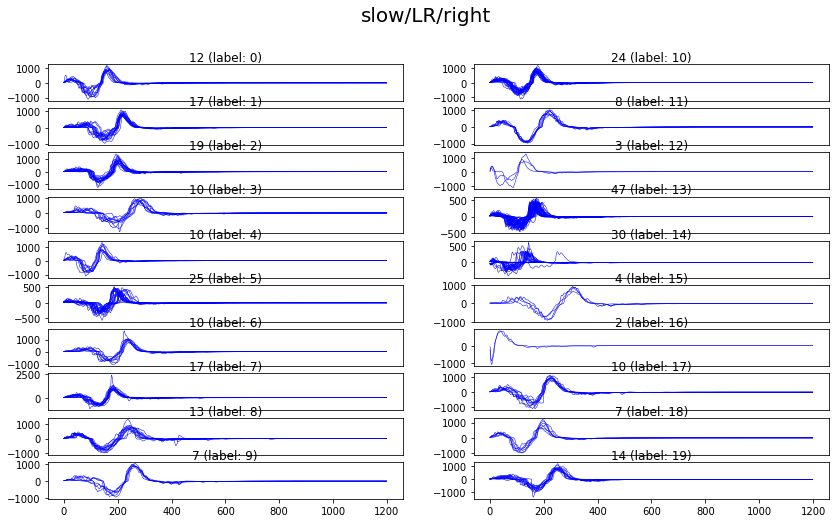

In [ ]:
measurement_setup = 'slow/LR/right'
motions.clusteringMotions(measurement_setup)
keepingLabel = [0,1,2,3,4,5,6,7,8,9,10,11,15,17,18,19]
motions.filteringMotionsForTraining(measurement_setup, keepingLabel)

### fast / RL 

#### left

number of extracted motions for network train: 151


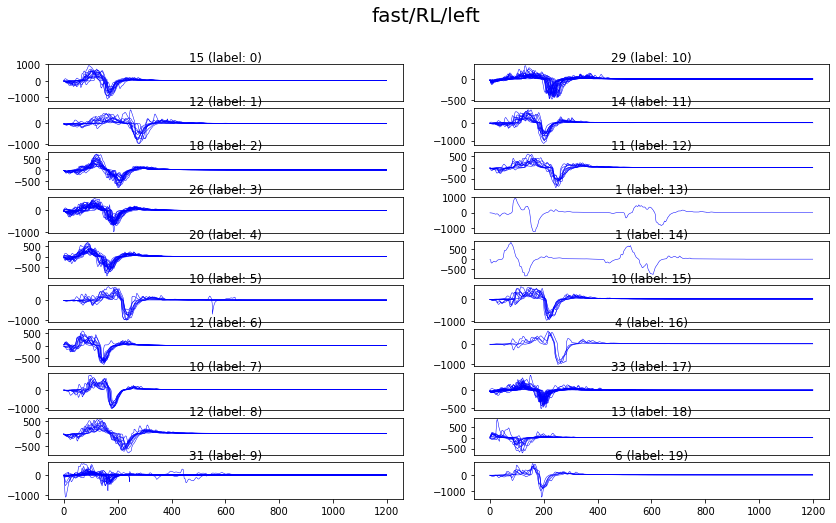

In [ ]:
measurement_setup = 'fast/RL/left'
motions.clusteringMotions(measurement_setup)
keepingLabel = [0,2,3,4,8,10,11,12,19]
motions.filteringMotionsForTraining(measurement_setup, keepingLabel)

#### right 

number of extracted motions for network train: 224


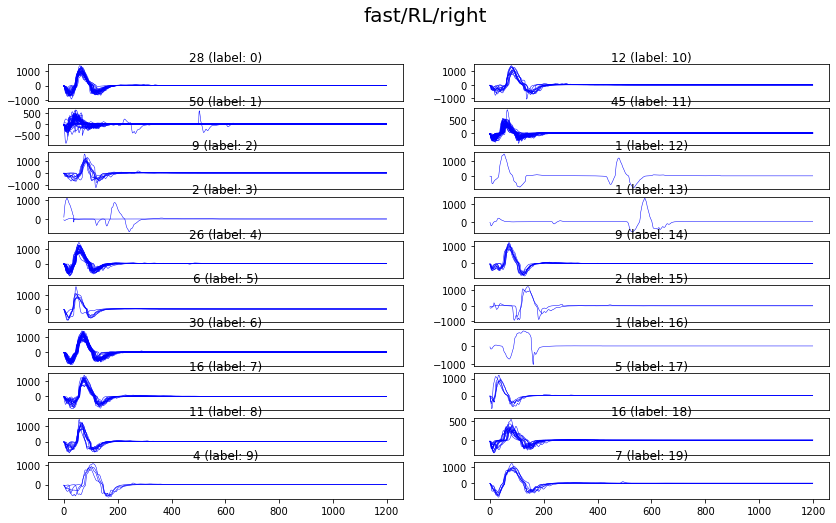

In [ ]:
measurement_setup = 'fast/RL/right'
motions.clusteringMotions(measurement_setup)
keepingLabel = [0,2,4,5,6,7,8,9,10,11,14,17,18,19]
motions.filteringMotionsForTraining(measurement_setup, keepingLabel)

### slow / RL 

#### left

number of extracted motions for network train: 171


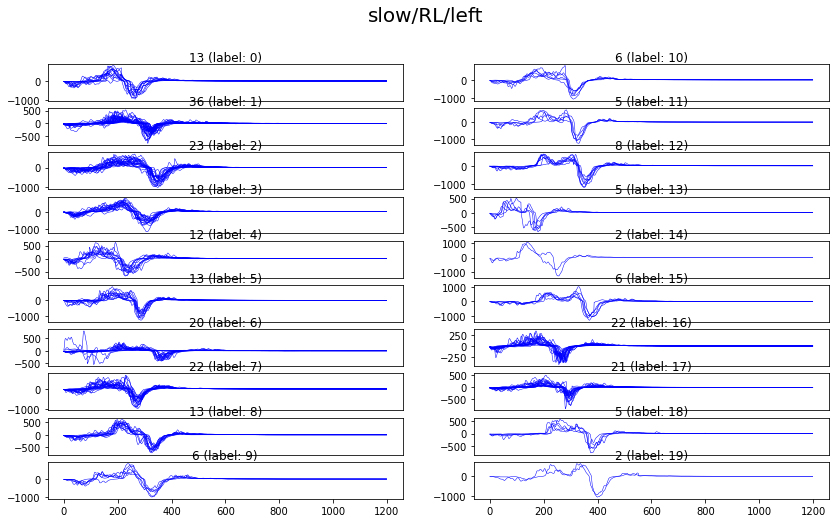

In [ ]:
measurement_setup = 'slow/RL/left'
motions.clusteringMotions(measurement_setup)
keepingLabel = [0,1,2,3,4,5,7,8,9,10,11,14,19]
motions.filteringMotionsForTraining(measurement_setup, keepingLabel)

#### right 

number of extracted motions for network train: 236


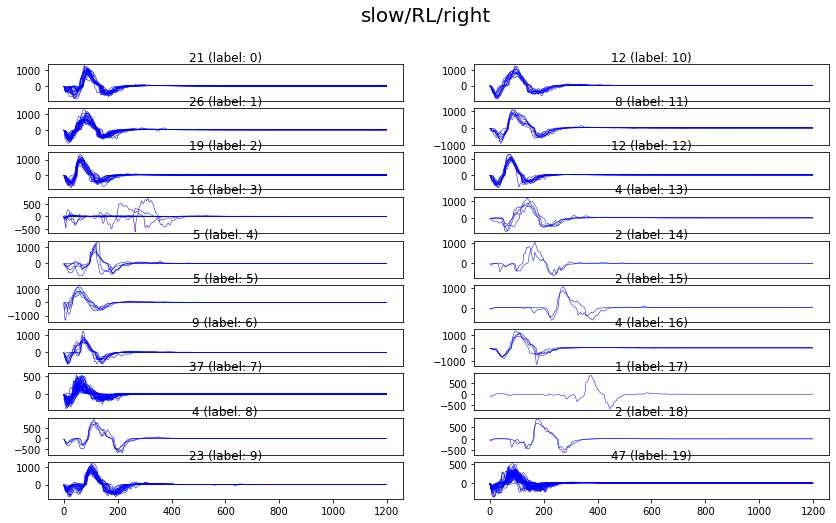

In [ ]:
measurement_setup = 'slow/RL/right'
motions.clusteringMotions(measurement_setup)
keepingLabel = [0,1,2,5,6,7,8,9,10,11,12,13,14,16,17,18,19]
motions.filteringMotionsForTraining(measurement_setup, keepingLabel)

# Get zeroCrossings and Vectors

In [ ]:
def zeroCrossings(self, measurement_setup, minimalDistance=12): 
    maxLength = 20 
    
    self.vector = [] 
    for motion in self.filteredMotions[measurement_setup]: 

        c = np.where(np.roll(motion, -1)*motion < 0)[0][...,np.newaxis]
        ranges = np.hstack((np.roll(c, 1), c)) 
        ranges[0,0] = 1
        
        val = np.empty([ranges.shape[0],2])
        for i,r in enumerate(ranges):
            arr = motion[r[0]:r[1]]
            val[i] = [r[1], arr[np.argmax(np.abs(arr))]]

        self.vector.append(val)
        
    self.flattenVector[measurement_setup] = self.vector[0][:3,:]
    for vec in self.vector[1:]: 
        self.flattenVector[measurement_setup] = np.vstack((self.flattenVector[measurement_setup], vec[:3,:]))
        
motionAnalysis.zeroCrossings = zeroCrossings

In [ ]:
def runZeroCrossings(direction, distanceList):
    for dis in distanceList:
        setup = os.path.join("fast", direction, dis)
        motions.zeroCrossings(setup)
        print("for {}, number of motions is {}".format(setup,len(motions.flattenVector[setup])))    

    print("")
    for dis in distanceList:
        setup = os.path.join("slow", direction, dis)
        motions.zeroCrossings(setup)
        print("for {}, number of motions is {}".format(setup,len(motions.flattenVector[setup])))    

In [ ]:
motions.filteredMotions['slow/LR/4m']

array([[21.9611, 23.1979, 24.7126, ...,  0.    ,  0.    ,  0.    ],
       [22.0495, 23.8292, 25.5127, ...,  0.    ,  0.    ,  0.    ],
       [22.6552, 24.5412, 26.5101, ...,  0.    ,  0.    ,  0.    ],
       ...,
       [20.8095, 21.6718, 22.9265, ...,  0.    ,  0.    ,  0.    ],
       [21.2818, 46.1383, 51.1082, ...,  0.    ,  0.    ,  0.    ],
       [22.7295, 25.3317, 28.0458, ...,  0.    ,  0.    ,  0.    ]])

## get zero crossings 
### fast & slow / LR / 1m - 5m

In [ ]:
runZeroCrossings("LR", distanceList)

for fast/LR/1m, number of motions is 684
for fast/LR/2m, number of motions is 579
for fast/LR/3m, number of motions is 573
for fast/LR/4m, number of motions is 441
for fast/LR/5m, number of motions is 432

for slow/LR/1m, number of motions is 621
for slow/LR/2m, number of motions is 552
for slow/LR/3m, number of motions is 687
for slow/LR/4m, number of motions is 534
for slow/LR/5m, number of motions is 372


### fast & slow / RL / 1m - 5m 

In [ ]:
runZeroCrossings("RL", distanceList)

for fast/RL/1m, number of motions is 679
for fast/RL/2m, number of motions is 495
for fast/RL/3m, number of motions is 495
for fast/RL/4m, number of motions is 483
for fast/RL/5m, number of motions is 579

for slow/RL/1m, number of motions is 576
for slow/RL/2m, number of motions is 570
for slow/RL/3m, number of motions is 405
for slow/RL/4m, number of motions is 456
for slow/RL/5m, number of motions is 590


### corner sensors 

In [ ]:
# fast&slow / LR / left & right 

runZeroCrossings("LR", cornerList)


for fast/LR/left, number of motions is 453
for fast/LR/right, number of motions is 648

for slow/LR/left, number of motions is 348
for slow/LR/right, number of motions is 621


In [ ]:
# fast&slow / RL / left & right 

runZeroCrossings("RL", cornerList)

for fast/RL/left, number of motions is 453
for fast/RL/right, number of motions is 672

for slow/RL/left, number of motions is 513
for slow/RL/right, number of motions is 708


In [ ]:
for dis in distanceList: 
    print('fast/LR/'+dis)

fast/LR/1m
fast/LR/2m
fast/LR/3m
fast/LR/4m
fast/LR/5m


## Plotting vectors 

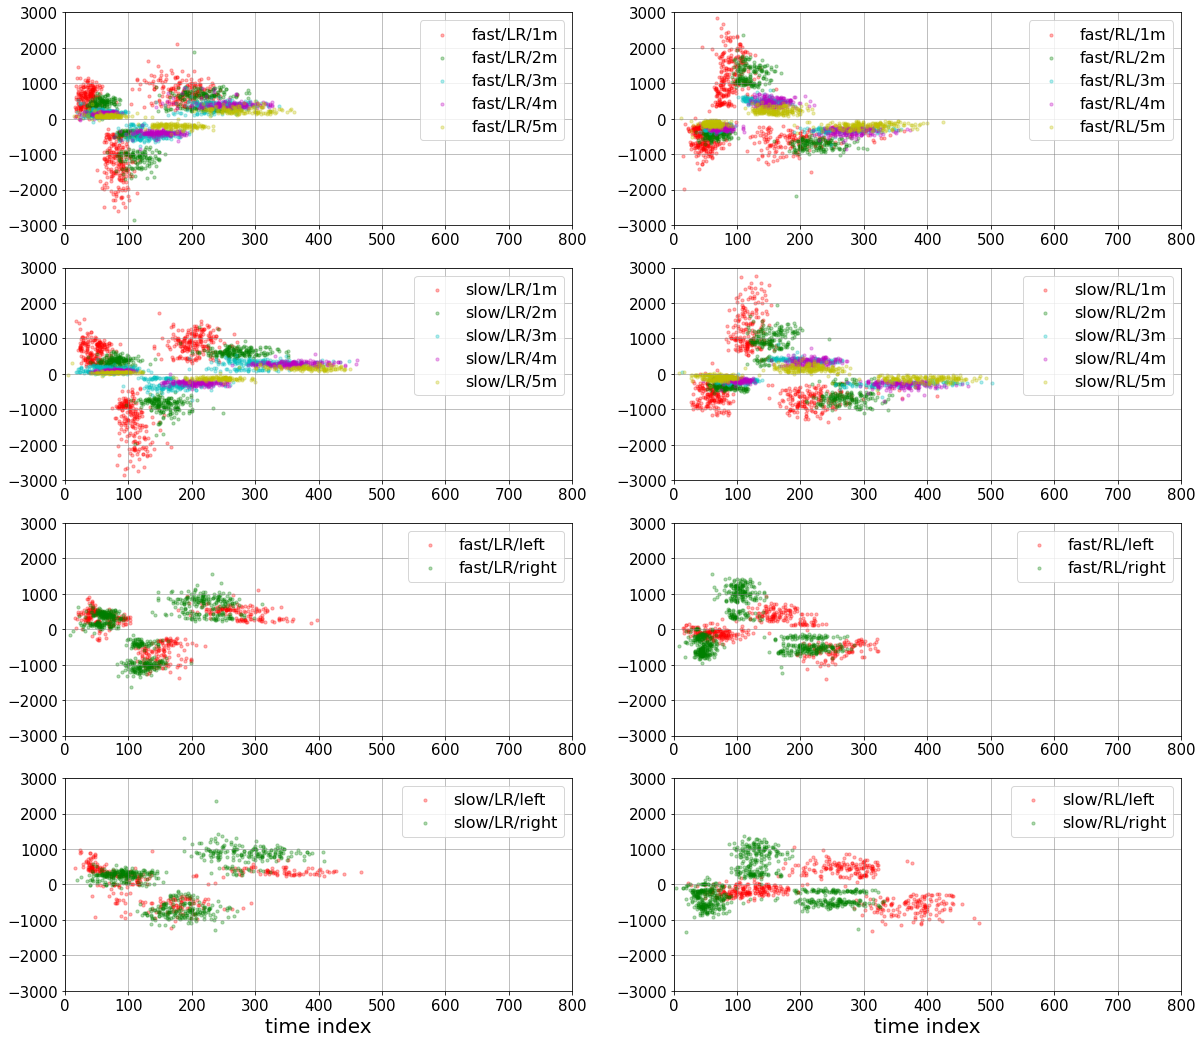

In [ ]:
import matplotlib as mpl

label_size = 15
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

def PlottingVectors(): 

    plt.figure(figsize=(20,18))
    
    markerSize = 10
    xRange = [0, 800]
    yRange = [-3000, 3000]
    fontSizeLegend = 16
    fontSizeXLabel = 16
    alphaValue = 0.3
    colorList = ['r','g','c','m','y']
    
    plt.subplot(4,2,1)
    plt.grid(color='grey', linestyle='-', linewidth=0.5)
    for i, dis in enumerate(distanceList): 
        condition = 'fast/LR/'+dis

        plt.scatter(motions.flattenVector[condition][:,0], 
                    motions.flattenVector[condition][:,1], 
                    c=colorList[i], s=markerSize, label=condition,alpha=alphaValue)
    _ = plt.legend(fontsize=fontSizeLegend)
    _ = plt.xlim(xRange)
    _ = plt.ylim(yRange)
#    _ = plt.xlabel("time index")

    plt.subplot(4,2,3)
    plt.grid(color='grey', linestyle='-', linewidth=0.5)
    for i, dis in enumerate(distanceList): 
        condition = 'slow/LR/'+dis

        plt.scatter(motions.flattenVector[condition][:,0], 
                    motions.flattenVector[condition][:,1], 
                    c=colorList[i], s=markerSize, label=condition,alpha=alphaValue)
    _ = plt.legend(fontsize=fontSizeLegend)
    _ = plt.xlim(xRange)
    _ = plt.ylim(yRange)
#    _ = plt.xlabel("time index")

    plt.subplot(4,2,2)
    plt.grid(color='grey', linestyle='-', linewidth=0.5)
    for i, dis in enumerate(distanceList): 
        condition = 'fast/RL/'+dis

        plt.scatter(motions.flattenVector[condition][:,0], 
                    motions.flattenVector[condition][:,1], 
                    c=colorList[i], s=markerSize, label=condition,alpha=alphaValue)
    _ = plt.legend(fontsize=fontSizeLegend)
    _ = plt.xlim(xRange)
    _ = plt.ylim(yRange)
#    _ = plt.xlabel("time index")

    plt.subplot(4,2,4)
    plt.grid(color='grey', linestyle='-', linewidth=0.5)
    for i, dis in enumerate(distanceList): 
        condition = 'slow/RL/'+dis

        plt.scatter(motions.flattenVector[condition][:,0], 
                    motions.flattenVector[condition][:,1], 
                    c=colorList[i], s=markerSize, label=condition,alpha=alphaValue)
    _ = plt.legend(fontsize=fontSizeLegend)
    _ = plt.xlim(xRange)
    _ = plt.ylim(yRange)
#    _ = plt.xlabel("time index")

    plt.subplot(4,2,5)
    plt.grid(color='grey', linestyle='-', linewidth=0.5)
    for i, dis in enumerate(cornerList): 
        condition = 'fast/LR/'+dis

        plt.scatter(motions.flattenVector[condition][:,0], 
                    motions.flattenVector[condition][:,1], 
                    c=colorList[i], s=markerSize, label=condition,alpha=alphaValue)
    _ = plt.legend(fontsize=fontSizeLegend)
    _ = plt.xlim(xRange)
    _ = plt.ylim(yRange)
#    _ = plt.xlabel("time index")


    plt.subplot(4,2,7)
    plt.grid(color='grey', linestyle='-', linewidth=0.5)
    for i, dis in enumerate(cornerList): 
        condition = 'slow/LR/'+dis

        plt.scatter(motions.flattenVector[condition][:,0], 
                    motions.flattenVector[condition][:,1], 
                    c=colorList[i], s=markerSize, label=condition,alpha=alphaValue)
    _ = plt.legend(fontsize=fontSizeLegend)
    _ = plt.xlim(xRange)
    _ = plt.ylim(yRange)
    _ = plt.xlabel("time index", fontsize=20)

    plt.subplot(4,2,6)
    plt.grid(color='grey', linestyle='-', linewidth=0.5)
    for i, dis in enumerate(cornerList): 
        condition = 'fast/RL/'+dis

        plt.scatter(motions.flattenVector[condition][:,0], 
                    motions.flattenVector[condition][:,1], 
                    c=colorList[i], s=markerSize, label=condition,alpha=alphaValue)
    _ = plt.legend(fontsize=fontSizeLegend)
    _ = plt.xlim(xRange)
    _ = plt.ylim(yRange)
#    _ = plt.xlabel("time index")


    plt.subplot(4,2,8)
    plt.grid(color='grey', linestyle='-', linewidth=0.5)
    for i, dis in enumerate(cornerList): 
        condition = 'slow/RL/'+dis

        plt.scatter(motions.flattenVector[condition][:,0], 
                    motions.flattenVector[condition][:,1], 
                    c=colorList[i], s=markerSize, label=condition,alpha=alphaValue)
    _ = plt.legend(fontsize=fontSizeLegend)
    _ = plt.xlim(xRange)
    _ = plt.ylim(yRange)
    _ = plt.xlabel("time index", fontsize=20)

        
PlottingVectors()    